## Mioflow - simulation

This notebook demonstrates how to infer trajectories using Mioflow with simulated data.

In [1]:
from MIOFlow.utils import generate_steps, set_seeds, config_criterion
from MIOFlow.models import make_model, Autoencoder
from MIOFlow.plots import plot_comparision, plot_losses
from MIOFlow.train import train_ae, training_regimen
from MIOFlow.constants import ROOT_DIR, DATA_DIR, NTBK_DIR, IMGS_DIR, RES_DIR
from MIOFlow.datasets import (
    make_diamonds, make_swiss_roll, make_tree, make_eb_data, 
    make_dyngen_data
)
from MIOFlow.geo import setup_distance
from MIOFlow.exp import setup_exp
from MIOFlow.eval import generate_plot_data, generate_trajectories

import os, pandas as pd, numpy as np, \
    seaborn as sns, matplotlib as mpl, matplotlib.pyplot as plt, \
    torch, torch.nn as nn

from tqdm.notebook import tqdm
import time

# This script aims to test the usefulness of similar samples

import os
###########################################
# set path to the downloaded UOTReg folder
###########################################
folder_path = '/Users/binghao/Desktop/Research/OT-singlecell/UOTReg/'
os.chdir(folder_path)
print("Current working directory:", os.getcwd())

import matplotlib
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
%matplotlib inline

from tqdm import tqdm, tqdm_notebook

import warnings
warnings.filterwarnings('ignore')
from IPython.display import clear_output

import sys
# sys.path.append("..")

import torch
from torch import nn
from torch.nn import functional as F
import torch.optim as optim
from typing import Tuple
from torch.utils.data import Dataset

from scipy.stats import ortho_group
from scipy.linalg import sqrtm

import time
import gc
from sklearn.decomposition import PCA

from copy import deepcopy

from sklearn.decomposition import PCA
from sklearn.datasets import make_spd_matrix

from scipy.stats import ortho_group, multivariate_normal

import random

import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from matplotlib.cm import viridis

os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

Current working directory: /Users/binghao/Desktop/Research/OT-singlecell/UOTReg


In [2]:
# setup WIN
DIM = 2
BATCH_SIZE = 64 # modify the 
device = "cpu"

LAMBDA = 5
G_LR = 1e-4
D_LR = 0.0005
bn = False
MAX_ITER = 200001

D_ITERS = 50
T_ITERS = 10
G_ITERS = 50

# Parameters for input distributions
NUM = 10
ALPHAS = np.array([1. / NUM for _ in range(NUM)])

seed_list = []

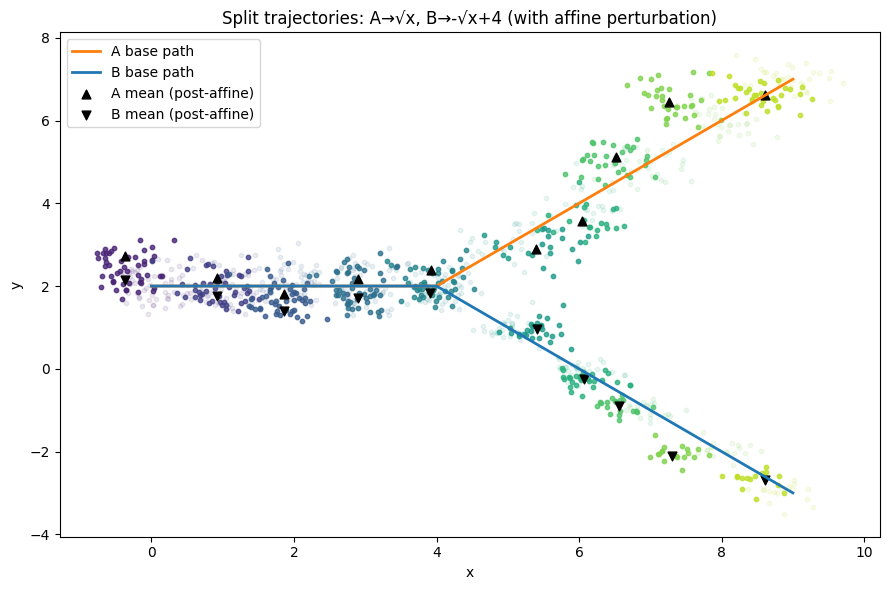

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch

# ---------------------- Affine (one-knob strength) --------------------------

def make_affine(strength=0.50, rotation_max_deg=10, scale_max=0.20, b_sigma_max=0.30):
    """
    Generate an affine map (A,b) with controllable 'strength':
      strength=0  -> A≈I, b≈0
      strength=1  -> full ranges of rotation/scale/translation
    """
    th = np.deg2rad(np.random.uniform(-rotation_max_deg*strength, rotation_max_deg*strength))
    c, s = np.cos(th), np.sin(th)
    R = np.array([[c, -s], [s, c]])

    s1 = 1.0 + strength*np.random.uniform(-scale_max, scale_max)
    s2 = 1.0 + strength*np.random.uniform(-scale_max, scale_max)

    A  = R @ np.diag([s1, s2]) @ R.T
    b  = np.random.randn(2) * (b_sigma_max*strength)
    return A, b

# ---------------------- Configuration ---------------------------------------

seed = 23
np.random.seed(seed)

x   = np.arange(10)              # 0..9
NUM = len(x)

yA_base = np.where(x <= 4, 2.0, x - 2)        # upper comp path
yB_base = np.where(x <= 4, 2.0, -x + 6.0) # lower comp path

colors = plt.cm.viridis(np.linspace(0.1, 0.9, NUM))

n_per_gauss  = 50
dataset_size = 500
pi_A         = 0.5

delta_pre  = 0.25
delta_post = 0.00

# >>> changed jitter logic
# Remove x-jitter entirely; only add small y-only jitter for t in {0..4}.
y_only_jitter_pre = 0.03  # magnitude for the early shared phase

sig_x_A, sig_y_A = 0.32, 0.30
sig_x_B, sig_y_B = 0.22, 0.20
cov_A = np.diag([sig_x_A**2, sig_y_A**2])
cov_B = np.diag([sig_x_B**2, sig_y_B**2])

strength = 0.5
per_time_affine = True

datasets_acc = []
Ysamplers_acc = []

# ---------------------- Main generation loop --------------------------------

plt.close('all')
plt.figure(figsize=(9, 6))
plt.title('Split trajectories: A→√x, B→-√x+4 (with affine perturbation)')

plt.plot(x, yA_base, color='tab:orange', linewidth=2.0, label='A base path')
plt.plot(x, yB_base, color='tab:blue',   linewidth=2.0, label='B base path')

datasets_acc = []

if not per_time_affine:
    A_global, b_global = make_affine(strength=strength)

for i in range(NUM):
    muA_center = np.array([x[i], yA_base[i]])
    muB_center = np.array([x[i], yB_base[i]])

    dA = +delta_pre  if i <= 4 else +delta_post
    dB = -delta_pre  if i <= 4 else -delta_post

    # >>> changed jitter logic (no x-jitter; only y-perturbation for t<=4)
    if i <= 4:
        jitter_y_A = np.random.randn() * y_only_jitter_pre
        jitter_y_B = np.random.randn() * y_only_jitter_pre
    else:
        jitter_y_A = 0.0
        jitter_y_B = 0.0

    mu_A = muA_center + np.array([0.0, dA + jitter_y_A])
    mu_B = muB_center + np.array([0.0, dB - jitter_y_B])  # keep B slightly lower

    counts_small = np.random.multinomial(n_per_gauss, [pi_A, 1 - pi_A])
    gt_A_small = np.random.multivariate_normal(mu_A, cov_A, counts_small[0])
    gt_B_small = np.random.multivariate_normal(mu_B, cov_B, counts_small[1])
    gt_small   = np.vstack([gt_A_small, gt_B_small])

    counts_full = np.random.multinomial(dataset_size, [pi_A, 1 - pi_A])
    gt_A = np.random.multivariate_normal(mu_A, cov_A, counts_full[0])
    gt_B = np.random.multivariate_normal(mu_B, cov_B, counts_full[1])
    gt_data = np.vstack([gt_A, gt_B])
    comp_full = np.array([0]*counts_full[0] + [1]*counts_full[1])

    if per_time_affine:
        A, b = make_affine(strength=strength)
    else:
        A, b = A_global, b_global

    pt_small = (gt_small @ A.T) + b
    pt_data  = (gt_data  @ A.T) + b

    datasets_acc.append(torch.from_numpy(pt_data).float())

    mu_pt_A = A @ mu_A + b
    mu_pt_B = A @ mu_B + b

    col = colors[i]
    plt.scatter(gt_small[:,0], gt_small[:,1], color=col, s=10, alpha=0.10)
    plt.scatter(pt_small[:,0], pt_small[:,1], color=col, s=10, alpha=0.80)

    if i == 0:
        plt.scatter(*mu_pt_A, color='black', marker='^', s=40, label='A mean (post-affine)')
        plt.scatter(*mu_pt_B, color='black', marker='v', s=40, label='B mean (post-affine)')
    else:
        plt.scatter(*mu_pt_A, color='black', marker='^', s=40)
        plt.scatter(*mu_pt_B, color='black', marker='v', s=40)

plt.legend()
plt.xlabel('x'); plt.ylabel('y')
plt.tight_layout()
plt.show()


In [6]:
# set up datasets
def random_sample(tensor, sample_size):
    # Ensure sample_size does not exceed the first dimension of the tensor
    assert sample_size <= tensor.size(0), "Sample size cannot be larger than the number of samples in the tensor" 
    # Randomly select indices
    indices = torch.randperm(tensor.size(0))[:sample_size]
    # Select and return the random samples
    sampled_tensor = tensor[indices]
    
    return sampled_tensor

In [7]:
import pandas as pd
import numpy as np

# Assuming `datasets` is your list of 10 (N, 2) ndarray elements
df_acc_list = []
for i, data in enumerate(datasets_acc):
    if(i>=1 and i<=8):
        # Create a DataFrame for each element with 'samples', 'd1', and 'd2' columns
        temp_df = pd.DataFrame(data, columns=['d1', 'd2'])
        temp_df['samples'] = np.int64(i)  # Set the 'samples' column to the index value (0 to 9)
        df_acc_list.append(temp_df)

# Concatenate all DataFrames in the list into one DataFrame
df = pd.concat(df_acc_list, ignore_index=True)

# Reorder columns
df = df[['samples', 'd1', 'd2']]

In [8]:
set_seeds(0)
use_cuda = torch.cuda.is_available()
print(use_cuda)

# This is True if we want to holdout (or skip) one timepoint during training. It is used to test the accuracy of the trajectories on unseen data.
hold_one_out = False
hold_out = 7

# The dimensions in the input space, it is columns - 1 because we assume one column is equal to "samples".
model_features = len(df.columns) - 1
groups = sorted(df.samples.unique())
print(groups)

False
[np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5), np.int64(6), np.int64(7), np.int64(8)]


In [23]:
# These determine the logic flow for training: 
#   use_emb=True use_gae=False is only the encoder to match the approximation of the geodesic.
#   use_emb=False use_gae=True the full Geodesic Autoencoder (GAE), i.e. matching the geodesic and a reconstruction loss.
#   use_emb=False use_gae=False Is not using the GAE.
#   use_emb=True use_gae=True, is redundant and should raise an error. 
use_emb = False
use_gae = False

need_to_train_gae = (use_emb or use_gae) and use_emb != use_gae

# If the reconstruction loss needs to be computed.
recon = use_gae and not use_emb 

# These are training GAE hyperparameters needed for training
# Distance_type in ['gaussian', 'alpha_decay'], and Gaussian scale
distance_type = 'phate'
rbf_length_scale=0.05
knn=5
dist = setup_distance(distance_type, rbf_length_scale=rbf_length_scale, knn=knn)

#Can be changed depending on the dataset
n_epochs_emb = 1000
samples_size_emb = (30, )

# Layers for the Geodesic Autoencoder
gae_embedded_dim = 5
encoder_layers = [model_features, 32, gae_embedded_dim]

gae = Autoencoder(
    encoder_layers = encoder_layers,
    decoder_layers = encoder_layers[::-1],
    activation='ReLU', use_cuda = use_cuda
)
optimizer = torch.optim.AdamW(gae.parameters())

In [24]:
# Added in extra cell just for iterative programming / running of code
#   but could be added to code block above

if need_to_train_gae:
    start_time_geo = time.time()

    losses = train_ae(
        gae, df, groups, optimizer, 
        n_epochs=n_epochs_emb, sample_size=samples_size_emb,
        noise_min_scale=0.009, noise_max_scale=0.015, 
        dist=dist, recon=recon, use_cuda=use_cuda,
        hold_one_out=hold_one_out, hold_out=hold_out
    )
    run_time_geo = time.time() - start_time_geo

    print(run_time_geo)
    autoencoder = gae
else:
    autoencoder = None

In [25]:
set_seeds(10)

#Directory where results are saved
exp_name = 'test'

# density loss knn
use_density_loss = True

# Weight of density (not percentage of total loss)
lambda_density = 5

# For petal=LeakyReLU / dyngen=CELU
activation = 'CELU'

# Can change but we never really do, mostly depends on the dataset.
layers = [16,32,16]

# Scale of the noise in the trajectories. Either len(groups)*[float] or None. Should be None if using an adaptative ODE solver.
sde_scales = len(groups)*[0.2] 

if recon:    
    model_features = gae_embedded_dim

model = make_model(
    model_features, layers, 
    activation=activation, scales=sde_scales, use_cuda=use_cuda
)

In [26]:
# Basically "batch size"
sample_size=(30, )

# Training specification
n_local_epochs = 0
n_epochs = 50
n_post_local_epochs = 0

# Using the reverse trajectories to train
reverse_schema = False
# each reverse_n epoch
reverse_n = 2


criterion_name = 'ot'
criterion = config_criterion(criterion_name)

optimizer = torch.optim.AdamW(model.parameters())

# Bookkeeping variables
batch_losses = []
globe_losses = []
if hold_one_out and hold_out in groups:
    local_losses = {f'{t0}:{t1}':[] for (t0, t1) in generate_steps(groups) if hold_out not in [t0, t1]}
else:
    local_losses = {f'{t0}:{t1}':[] for (t0, t1) in generate_steps(groups)}

# For creating output.
n_points = 100
n_trajectories = 100
n_bins = 100


In [27]:
phate_dims = 5
lambda_density = 10
lambda_energy = 0.01

opts = {
    'phate_dims': phate_dims,
    'use_cuda': use_cuda,
    'model_features': model_features,
    'exp_name': exp_name,
    'groups': groups,
    'sample_size': sample_size,
    'use_emb': use_emb,
    'n_local_epochs': n_local_epochs,
    'n_epochs': n_epochs,
    'n_post_local_epochs': n_post_local_epochs,
    'criterion_name': criterion_name,
    'hold_one_out': hold_one_out,
    'use_density_loss': use_density_loss,
    'n_points': n_points,
    'n_trajectories': n_trajectories,
    'n_bins': n_bins,
    'autoencoder': autoencoder,
    'activation_ode': activation,
    'layer': layers,
    'lambda_density':lambda_density,
    'use_gae': use_gae,
    'sde_scales': sde_scales,
    'hold_out':hold_out,
    'encoder_layers': encoder_layers,
    'n_epochs_emb': n_epochs_emb,
    'samples_size_emb': samples_size_emb,
    'recon': recon,
    'distance_type':distance_type,
    'rbf_length_scale':rbf_length_scale,
    'reverse_schema': reverse_schema,
    'reverse_n': reverse_n
}

In [28]:
exp_dir, logger = setup_exp(RES_DIR, opts, exp_name) 

In [29]:
start_time = time.time()
local_losses, batch_losses, globe_losses = training_regimen(
    # local, global, local train structure
    n_local_epochs=n_local_epochs, 
    n_epochs=n_epochs, 
    n_post_local_epochs=n_post_local_epochs,
    
    # where results are stored
    exp_dir=exp_dir, 

    # BEGIN: train params
    model=model, df=df, groups=groups, optimizer=optimizer, 
    criterion=criterion, use_cuda=use_cuda,
    
    hold_one_out=hold_one_out, hold_out=hold_out,
    
    use_density_loss=use_density_loss, 
    lambda_density=lambda_density,
    
    autoencoder=autoencoder, use_emb=use_emb, use_gae=use_gae, 
    
    sample_size=sample_size, logger=logger,
    reverse_schema=reverse_schema, reverse_n=reverse_n,
    # END: train params

    plot_every=5,
    n_points=n_points, n_trajectories=n_trajectories, n_bins=n_bins, 
    #local_losses=local_losses, batch_losses=batch_losses, globe_losses=globe_losses
)
run_time = time.time() - start_time + run_time_geo if use_emb or use_gae else time.time() - start_time
logger.info(f'Total run time: {np.round(run_time, 5)}')

Pretraining Epoch: 0it [00:00, ?it/s]

Epoch:   0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Posttraining Epoch: 0it [00:00, ?it/s]

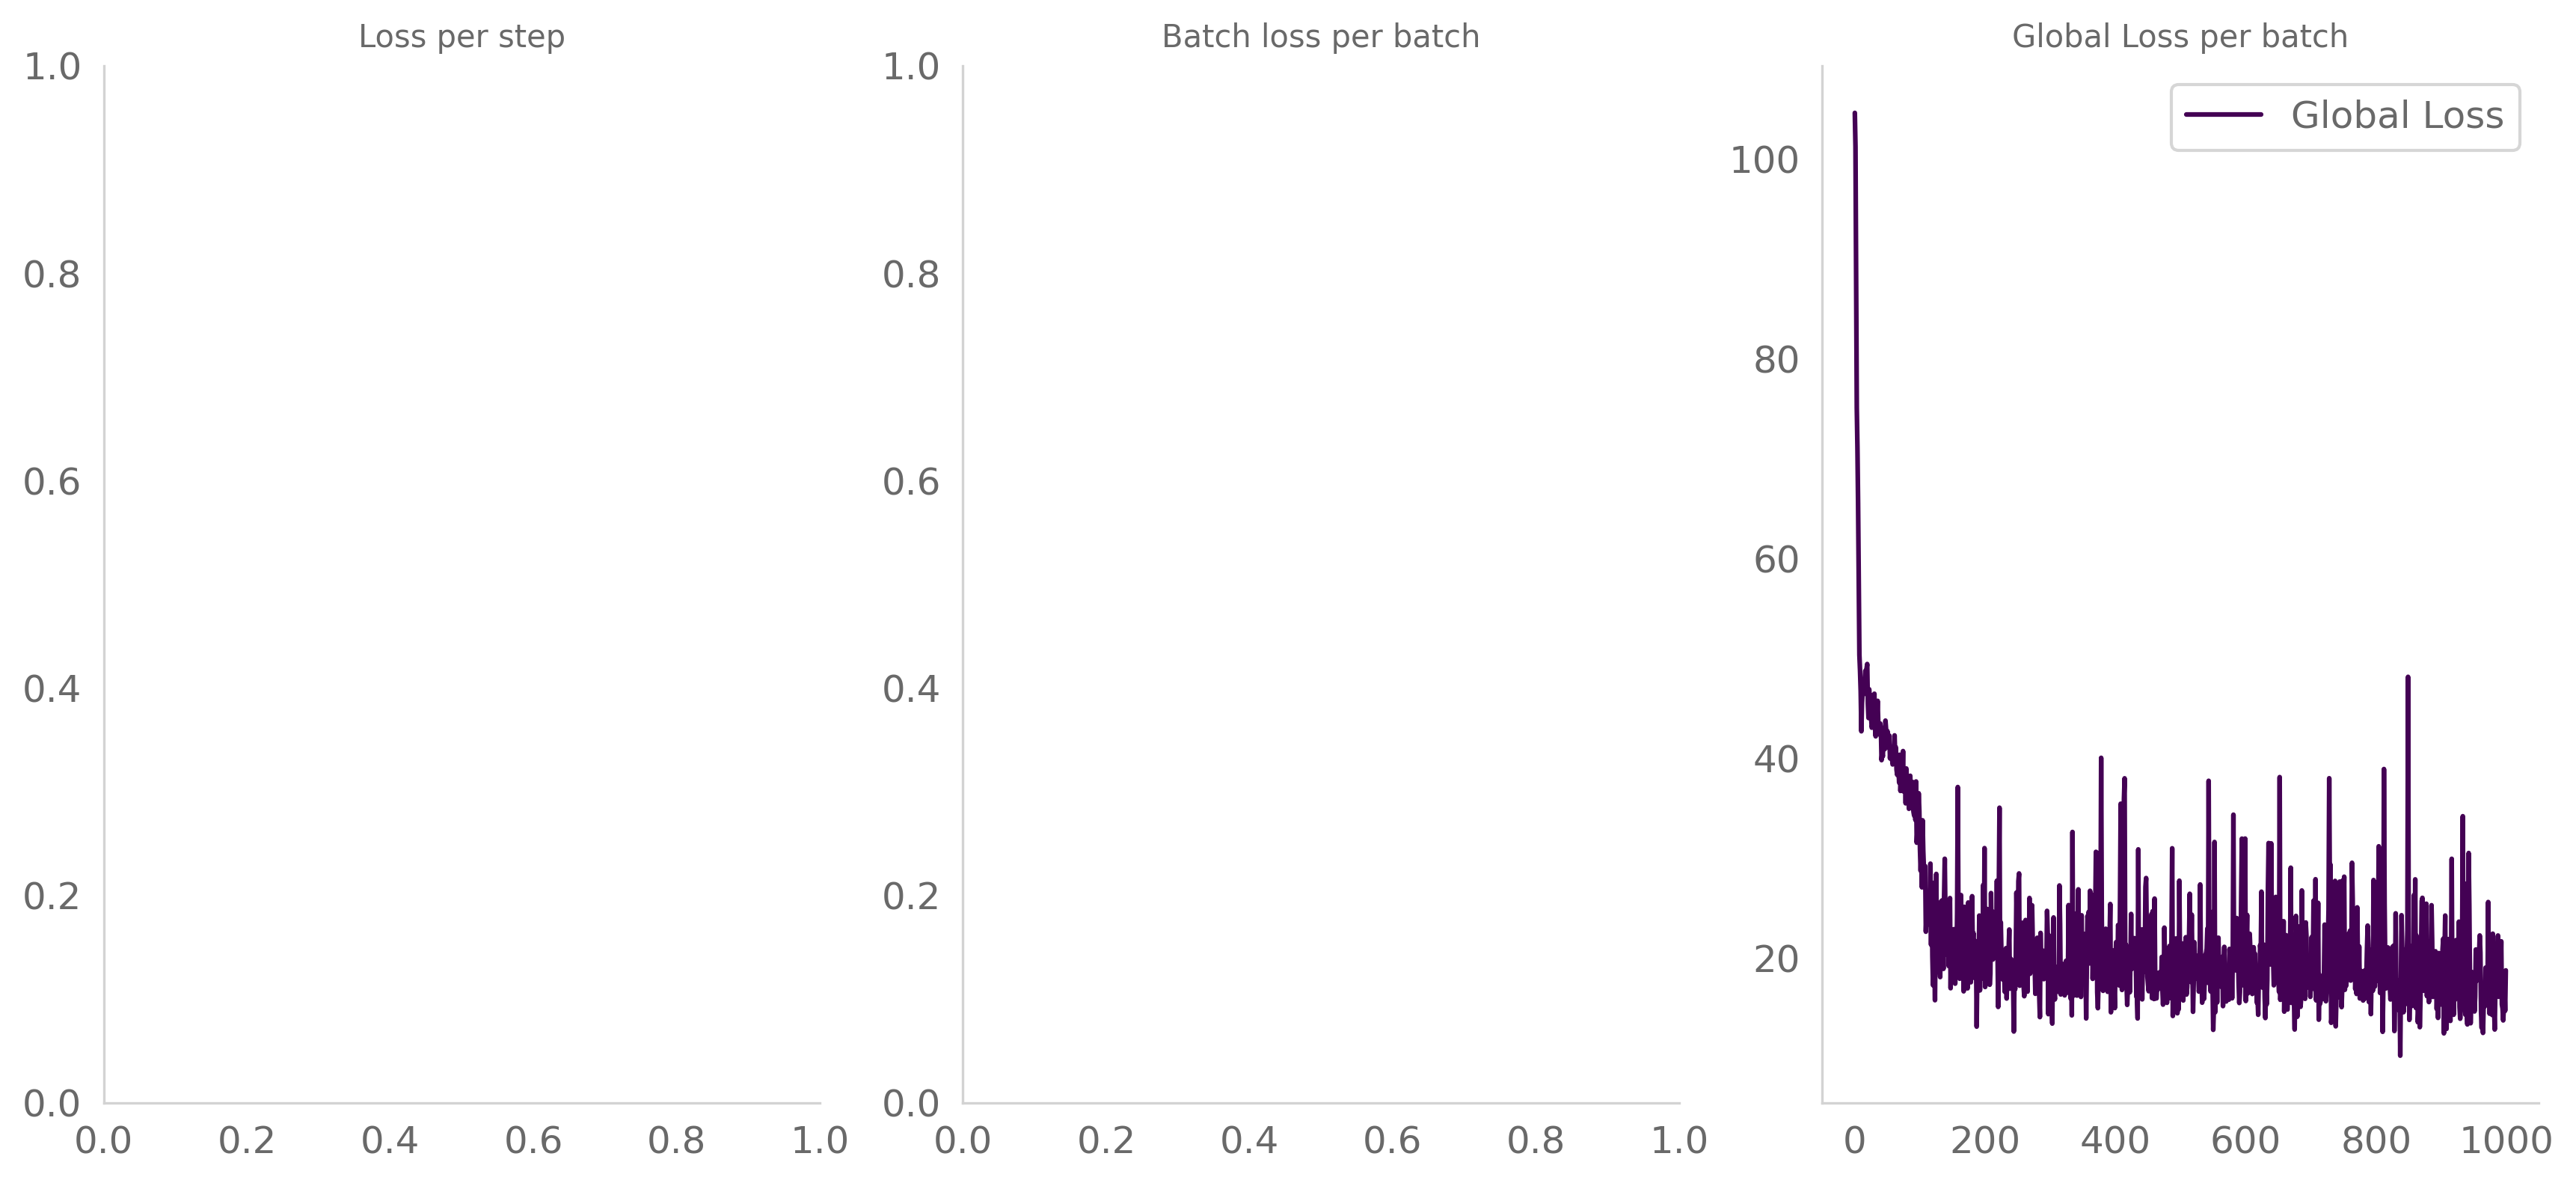

In [30]:
plot_losses(
    local_losses, batch_losses, globe_losses, 
    save=True, path=exp_dir, file='losses.png'
)

In [31]:
n_points = 20
generated, trajectories = generate_plot_data(
    model, df, n_points, n_trajectories, n_bins, use_cuda=use_cuda, samples_key='samples', logger=logger,
    autoencoder=autoencoder, recon=recon
)

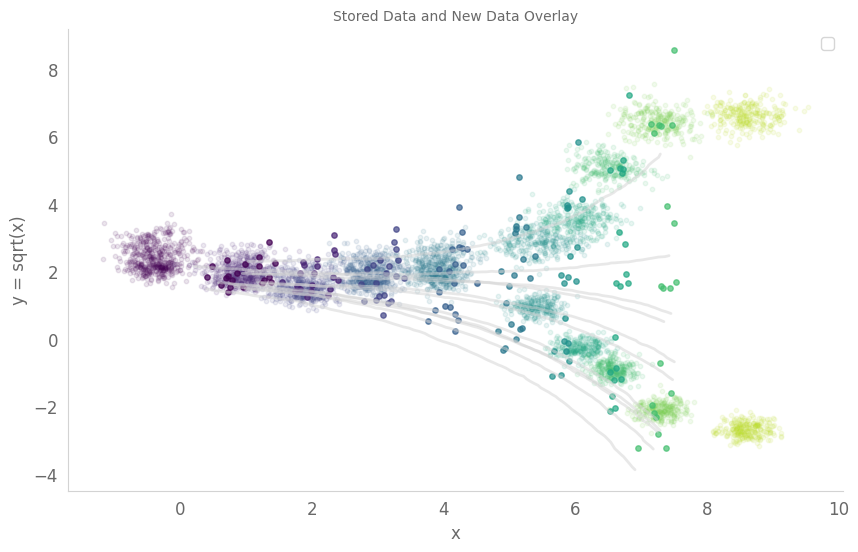

In [32]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from matplotlib.cm import viridis
# Plotting the original stored data points
x1 = np.linspace(0,9,100)
y1 = np.sqrt(x1)

# Initialize plot
plt.figure(figsize=(10, 6))

# Plot y = sqrt(x) with a light grey line
# plt.plot(x1, y1, color='lightgrey', linewidth=3)
# for i, sampled_data in enumerate(stored_truth):
#     plt.scatter(sampled_data[:, 0], sampled_data[:, 1],
#                 color=viridis(Normalize(0, NUM)(i)), s=10, alpha=0.1)
    
for i, sampled_data in enumerate(datasets_acc):
    plt.scatter(sampled_data.detach().numpy()[:, 0], sampled_data.detach().numpy()[:, 1],
                color=viridis(Normalize(0, NUM)(i)), s=10, alpha=0.1)

# Plot generated data points at each time point, colored by time point index
for i in range(max(df['samples'])):
    plt.scatter(generated[i, :, 0], generated[i, :, 1],
                color=viridis(Normalize(0, NUM)(i)), s=15, alpha=0.7)

# Plot trajectories
for j in range(trajectories.shape[1]):
    plt.plot(trajectories[:, j, 0], trajectories[:, j, 1],
             color='lightgrey', linewidth=2, alpha=0.5)
    if(j==10): break
    
# plt.scatter(GZ[:, 0], GZ[:, 1], color='darkgrey', s=20, marker='x', label="New Data")
# plt.scatter(perturbed_means[:, 0], perturbed_means[:, 1], color='black', s=30, marker='x', label="Perturbed Means")
# plt.scatter(ground_truth_means[:,0], ground_truth_means[:,1], color="black", s=50, marker='o', label="Ground Truth Mean" if i == 0 else "")


# Plot aesthetics
plt.xlabel("x")
plt.ylabel("y = sqrt(x)")
plt.title("Stored Data and New Data Overlay")
plt.legend()
plt.show()